# Speech Emotion Recognition (SER)

This notebook builds a Speech Emotion Recognition model using 4 popular datasets:
- RAVDESS
- CREMA-D
- TESS
- SAVEE

## Emotions Covered:
- Angry
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise (in some datasets)

## 1. Dataset Path Configuration

In [1]:
import os

# Set the path to the local dataset directory
# The dataset has been downloaded and extracted to the 'dataset' folder
data_path = os.path.join(os.getcwd(), 'dataset')

print(f"Dataset directory: {data_path}")
print(f"Dataset exists: {os.path.exists(data_path)}")

if os.path.exists(data_path):
    print("\n✓ Dataset is ready!")
    print(f"\nDataset contents:")
    
    # Count files recursively in each subdirectory
    subdirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    total_files = 0
    
    for subdir in sorted(subdirs):
        subdir_path = os.path.join(data_path, subdir)
        # Count all .wav files recursively
        num_files = sum(1 for root, dirs, files in os.walk(subdir_path) 
                       for f in files if f.endswith('.wav'))
        total_files += num_files
        print(f"  - {subdir}: {num_files} audio files")
    
    print(f"\n  Total: {total_files} audio files across all datasets")
else:
    print("\n✗ Dataset not found!")
    print("Please download the dataset from Kaggle or run the download cell.")

Dataset directory: /Users/ismatsamadov/speech_emotion_recognition/dataset
Dataset exists: True

✓ Dataset is ready!

Dataset contents:
  - Crema: 7442 audio files
  - Ravdess: 1440 audio files
  - Savee: 480 audio files
  - Tess: 2800 audio files

  Total: 12162 audio files across all datasets


## 2. Import Required Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Librosa version:", librosa.__version__)

TensorFlow version: 2.16.2
Librosa version: 0.11.0


/Users/ismatsamadov/speech_emotion_recognition/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 3. Explore Dataset Structure

In [3]:
# Create output directories
import os

# Define output directories
CHARTS_DIR = 'charts'
OUTPUTS_DIR = 'outputs'
ARTIFACTS_DIR = 'artifacts'

# Create directories if they don't exist
for directory in [CHARTS_DIR, OUTPUTS_DIR, ARTIFACTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ {directory}/ directory ready")

print("\nAll output directories created successfully!")

✓ charts/ directory ready
✓ outputs/ directory ready
✓ artifacts/ directory ready

All output directories created successfully!


In [4]:
# Explore dataset directory structure
import os

# Use the local dataset directory
data_path = os.path.join(os.getcwd(), 'dataset')

# Find all subdirectories
print(f"Exploring dataset structure at: {data_path}\n")
print("=" * 80)

for root, dirs, files in os.walk(data_path):
    # Only show first 2 levels to keep output clean
    depth = root.replace(data_path, '').count(os.sep)
    if depth < 2:
        indent = ' ' * 2 * depth
        print(f"{indent}{os.path.basename(root)}/")
        
        # Show sample files if any .wav files exist
        wav_files = [f for f in files if f.endswith('.wav')]
        if wav_files and depth == 1:
            print(f"{indent}  └─ {len(wav_files)} .wav files")
            if len(wav_files) <= 3:
                for f in wav_files[:3]:
                    print(f"{indent}     - {f}")
            else:
                for f in wav_files[:3]:
                    print(f"{indent}     - {f}")
                print(f"{indent}     ... and {len(wav_files) - 3} more")
        print()

print("=" * 80)

Exploring dataset structure at: /Users/ismatsamadov/speech_emotion_recognition/dataset

dataset/

  Savee/
    └─ 480 .wav files
       - JK_sa01.wav
       - JK_sa15.wav
       - DC_n13.wav
       ... and 477 more

  Tess/

  Ravdess/

  Crema/
    └─ 7442 .wav files
       - 1022_ITS_ANG_XX.wav
       - 1037_ITS_ANG_XX.wav
       - 1060_ITS_NEU_XX.wav
       ... and 7439 more



## 4. Data Loading and Label Extraction

We'll create functions to extract emotion labels from each dataset based on their naming conventions.

In [5]:
def get_emotion_ravdess(filename):
    """
    Extract emotion from RAVDESS filename
    Format: 03-01-{emotion}-01-01-01-01.wav
    Emotions: 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
    """
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fear',
        '07': 'disgust',
        '08': 'surprise'
    }
    parts = os.path.basename(filename).split('-')
    if len(parts) >= 3:
        return emotion_map.get(parts[2], 'unknown')
    return 'unknown'

def get_emotion_crema(filename):
    """
    Extract emotion from CREMA-D filename
    Format: 1001_DFA_ANG_XX.wav
    Emotions: SAD, ANG, DIS, FEA, HAP, NEU
    """
    emotion_map = {
        'SAD': 'sad',
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral'
    }
    parts = os.path.basename(filename).split('_')
    if len(parts) >= 3:
        return emotion_map.get(parts[2], 'unknown')
    return 'unknown'

def get_emotion_tess(filename):
    """
    Extract emotion from TESS filename
    Format: YAF_word_emotion.wav (e.g., YAF_date_disgust.wav)
    Emotions are in the filename as the last part before .wav
    """
    basename = os.path.basename(filename).lower()
    
    # Remove .wav extension and split by underscore
    name_without_ext = basename.replace('.wav', '')
    parts = name_without_ext.split('_')
    
    # The emotion is typically the last part
    if len(parts) >= 3:
        emotion = parts[-1]
        
        # Map variations to standard emotions
        emotion_map = {
            'angry': 'angry',
            'anger': 'angry',
            'disgust': 'disgust',
            'fear': 'fear',
            'happy': 'happy',
            'happiness': 'happy',
            'pleasant': 'happy',
            'ps': 'surprise',  # pleasant surprise
            'sad': 'sad',
            'sadness': 'sad',
            'neutral': 'neutral',
            'surprise': 'surprise',
            'surprised': 'surprise'
        }
        
        return emotion_map.get(emotion, 'unknown')
    
    return 'unknown'

def get_emotion_savee(filename):
    """
    Extract emotion from SAVEE filename
    Format: {SpeakerID}_{EmotionCode}{Number}.wav (e.g., DC_a01.wav, JK_sa15.wav)
    SpeakerIDs: DC, JE, JK, KL
    Emotions: a=anger, d=disgust, f=fear, h=happiness, n=neutral, sa=sadness, su=surprise
    """
    basename = os.path.basename(filename).lower()
    
    # Split by underscore to separate speaker ID and emotion code
    parts = basename.split('_')
    
    if len(parts) >= 2:
        # The second part contains emotion code + number
        emotion_part = parts[1].replace('.wav', '')
        
        # Check for two-letter codes first (sa, su)
        if emotion_part.startswith('sa'):
            return 'sad'
        elif emotion_part.startswith('su'):
            return 'surprise'
        # Then check single-letter codes
        elif emotion_part.startswith('a'):
            return 'angry'
        elif emotion_part.startswith('d'):
            return 'disgust'
        elif emotion_part.startswith('f'):
            return 'fear'
        elif emotion_part.startswith('h'):
            return 'happy'
        elif emotion_part.startswith('n'):
            return 'neutral'
    
    return 'unknown'

def get_emotion(filepath):
    """
    Automatically detect dataset type and extract emotion
    """
    filepath_lower = filepath.lower()
    
    if 'ravdess' in filepath_lower or 'actor_' in filepath_lower:
        return get_emotion_ravdess(filepath)
    elif 'crema' in filepath_lower:
        return get_emotion_crema(filepath)
    elif 'tess' in filepath_lower:
        return get_emotion_tess(filepath)
    elif 'savee' in filepath_lower:
        return get_emotion_savee(filepath)
    else:
        # Try to infer from filename
        if '-' in os.path.basename(filepath) and len(os.path.basename(filepath).split('-')) > 5:
            return get_emotion_ravdess(filepath)
        elif '_' in os.path.basename(filepath):
            # Try CREMA first, then TESS, then SAVEE
            emotion = get_emotion_crema(filepath)
            if emotion == 'unknown':
                emotion = get_emotion_tess(filepath)
            if emotion == 'unknown':
                emotion = get_emotion_savee(filepath)
            return emotion
        else:
            return 'unknown'
    
# Test the functions
print("Testing emotion extraction:")
print("=" * 50)
print("RAVDESS test:", get_emotion_ravdess("03-01-05-01-01-01-01.wav"))
print("CREMA test:", get_emotion_crema("1001_DFA_ANG_XX.wav"))
print("TESS test:", get_emotion_tess("YAF_date_disgust.wav"))
print("SAVEE tests:")
print("  DC_a01.wav:", get_emotion_savee("DC_a01.wav"))
print("  JK_sa15.wav:", get_emotion_savee("JK_sa15.wav"))
print("  DC_su01.wav:", get_emotion_savee("DC_su01.wav"))
print("=" * 50)

Testing emotion extraction:
RAVDESS test: angry
CREMA test: angry
TESS test: disgust
SAVEE tests:
  DC_a01.wav: angry
  JK_sa15.wav: sad
  DC_su01.wav: surprise


## 5. Feature Extraction

We'll extract multiple audio features:
- MFCC (Mel-frequency cepstral coefficients)
- Chroma
- Mel Spectrogram
- Zero Crossing Rate
- Spectral Features

In [6]:
def extract_features(file_path, duration=3, sr=22050):
    """
    Extract comprehensive audio features from audio file
    
    Parameters:
    - file_path: path to audio file
    - duration: maximum duration to load (in seconds)
    - sr: sampling rate
    
    Returns:
    - features: numpy array of concatenated features
    """
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, duration=duration, sr=sr)
        
        # Extract MFCC features (40 coefficients)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Extract Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_mean = np.mean(mel.T, axis=0)
        
        # Extract Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        contrast_mean = np.mean(contrast.T, axis=0)
        
        # Extract Tonnetz (Tonal Centroid Features)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sample_rate)
        tonnetz_mean = np.mean(tonnetz.T, axis=0)
        
        # Extract Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        zcr_mean = np.mean(zcr)
        
        # Extract Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
        rolloff_mean = np.mean(spectral_rolloff)
        
        # Concatenate all features
        features = np.hstack([
            mfccs_mean,
            chroma_mean,
            mel_mean,
            contrast_mean,
            tonnetz_mean,
            zcr_mean,
            rolloff_mean
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

print("Feature extraction function ready.")

Feature extraction function ready.


## 6. Load All Audio Files and Extract Features

In [7]:
# Collect all .wav files from the dataset
audio_files = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

print(f"Total audio files found: {len(audio_files)}")

# Display sample file paths
if len(audio_files) > 0:
    print("\nSample file paths:")
    for i in range(min(5, len(audio_files))):
        print(f"{i+1}. {audio_files[i]}")
        print(f"   Detected emotion: {get_emotion(audio_files[i])}")

Total audio files found: 12162

Sample file paths:
1. /Users/ismatsamadov/speech_emotion_recognition/dataset/Savee/JK_sa01.wav
   Detected emotion: sad
2. /Users/ismatsamadov/speech_emotion_recognition/dataset/Savee/JK_sa15.wav
   Detected emotion: sad
3. /Users/ismatsamadov/speech_emotion_recognition/dataset/Savee/DC_n13.wav
   Detected emotion: neutral
4. /Users/ismatsamadov/speech_emotion_recognition/dataset/Savee/DC_su09.wav
   Detected emotion: surprise
5. /Users/ismatsamadov/speech_emotion_recognition/dataset/Savee/DC_n07.wav
   Detected emotion: neutral


In [8]:
# Extract features and labels for all audio files
print("Extracting features from all audio files...")
print("This may take several minutes depending on the dataset size.\n")

features_list = []
labels_list = []
file_paths = []

# Process files with progress indication
total_files = len(audio_files)
for idx, file_path in enumerate(audio_files, 1):
    if idx % 100 == 0:
        print(f"Processing: {idx}/{total_files} files ({idx/total_files*100:.1f}%)")
    
    # Extract features
    features = extract_features(file_path)
    
    if features is not None:
        # Get emotion label
        emotion = get_emotion(file_path)
        
        if emotion != 'unknown':
            features_list.append(features)
            labels_list.append(emotion)
            file_paths.append(file_path)

print(f"\nFeature extraction complete!")
print(f"Successfully processed: {len(features_list)} files")
print(f"Skipped: {total_files - len(features_list)} files")

Extracting features from all audio files...
This may take several minutes depending on the dataset size.

Processing: 100/12162 files (0.8%)
Processing: 200/12162 files (1.6%)
Processing: 300/12162 files (2.5%)
Processing: 400/12162 files (3.3%)
Processing: 500/12162 files (4.1%)
Processing: 600/12162 files (4.9%)
Processing: 700/12162 files (5.8%)
Processing: 800/12162 files (6.6%)
Processing: 900/12162 files (7.4%)
Processing: 1000/12162 files (8.2%)
Processing: 1100/12162 files (9.0%)
Processing: 1200/12162 files (9.9%)
Processing: 1300/12162 files (10.7%)
Processing: 1400/12162 files (11.5%)
Processing: 1500/12162 files (12.3%)
Processing: 1600/12162 files (13.2%)
Processing: 1700/12162 files (14.0%)
Processing: 1800/12162 files (14.8%)
Processing: 1900/12162 files (15.6%)
Processing: 2000/12162 files (16.4%)
Processing: 2100/12162 files (17.3%)
Processing: 2200/12162 files (18.1%)
Processing: 2300/12162 files (18.9%)
Processing: 2400/12162 files (19.7%)
Processing: 2500/12162 file

## 7. Data Analysis and Visualization

In [9]:
# Create DataFrame for easier analysis
df = pd.DataFrame({
    'file_path': file_paths,
    'emotion': labels_list
})

# Add dataset source column
df['dataset'] = df['file_path'].apply(lambda x: 
    'RAVDESS' if 'ravdess' in x.lower() else
    'CREMA' if 'crema' in x.lower() else
    'TESS' if 'tess' in x.lower() else
    'SAVEE' if 'savee' in x.lower() else 'Unknown'
)

print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"\nEmotion distribution:")
emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

# Save emotion distribution to outputs
emotion_counts.to_csv(f'{OUTPUTS_DIR}/emotion_distribution.csv')
print(f"\n✓ Saved emotion distribution to {OUTPUTS_DIR}/emotion_distribution.csv")

# Dataset distribution
print(f"\nDataset distribution:")
dataset_counts = df['dataset'].value_counts()
print(dataset_counts)
dataset_counts.to_csv(f'{OUTPUTS_DIR}/dataset_distribution.csv')

# Display dataset info
print(f"\nFeature vector shape: {features_list[0].shape}")
print(f"Number of features per sample: {len(features_list[0])}")

Dataset Overview:
Total samples: 12162

Emotion distribution:
emotion
sad         1923
fear        1923
disgust     1923
happy       1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

✓ Saved emotion distribution to outputs/emotion_distribution.csv

Dataset distribution:
dataset
CREMA      7442
TESS       2800
RAVDESS    1440
SAVEE       480
Name: count, dtype: int64

Feature vector shape: (195,)
Number of features per sample: 195


✓ Saved: charts/01_emotion_distribution.png


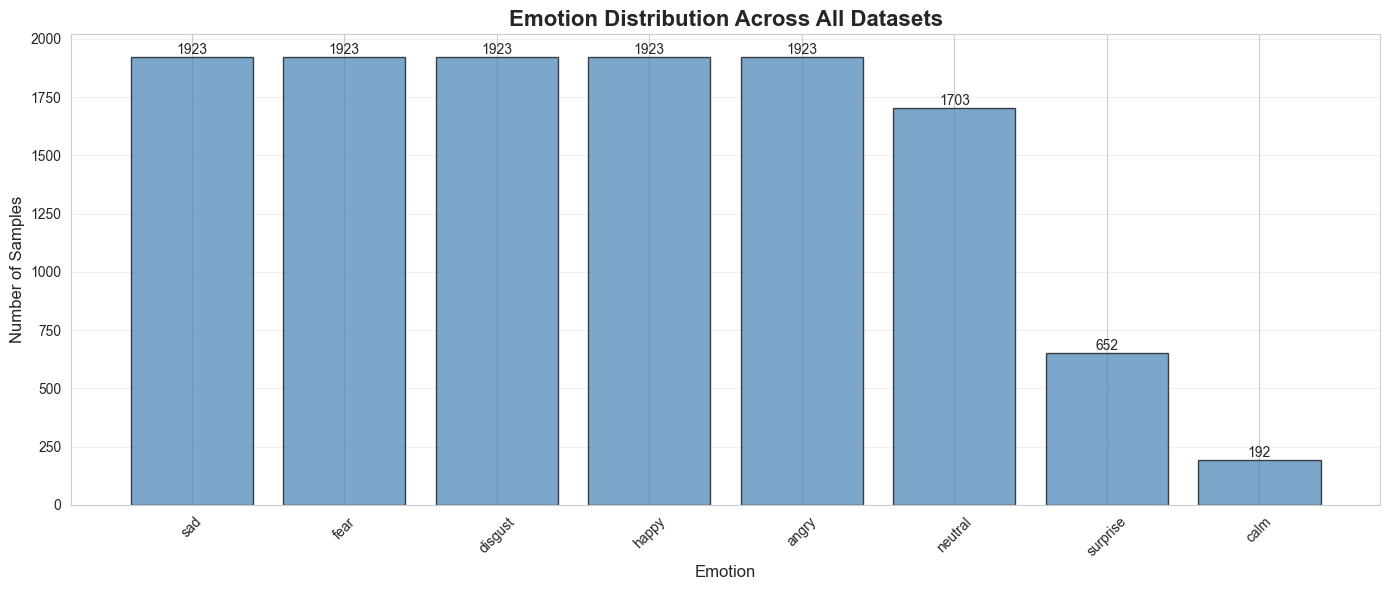

✓ Saved: charts/02_dataset_distribution_pie.png


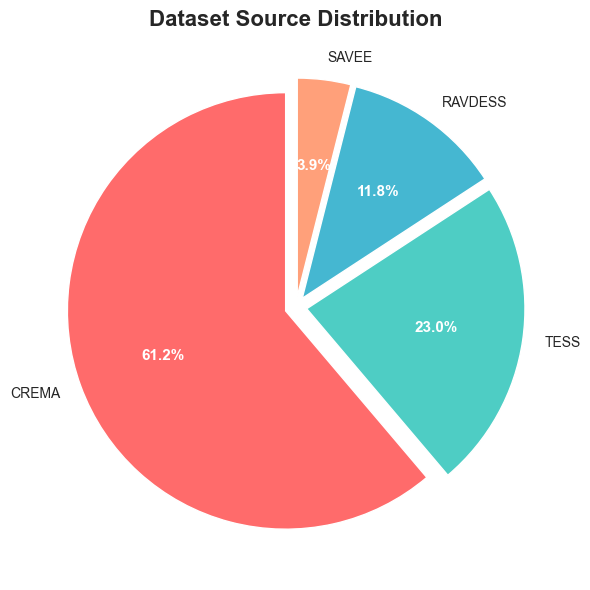

✓ Saved: charts/03_emotion_by_dataset_stacked.png


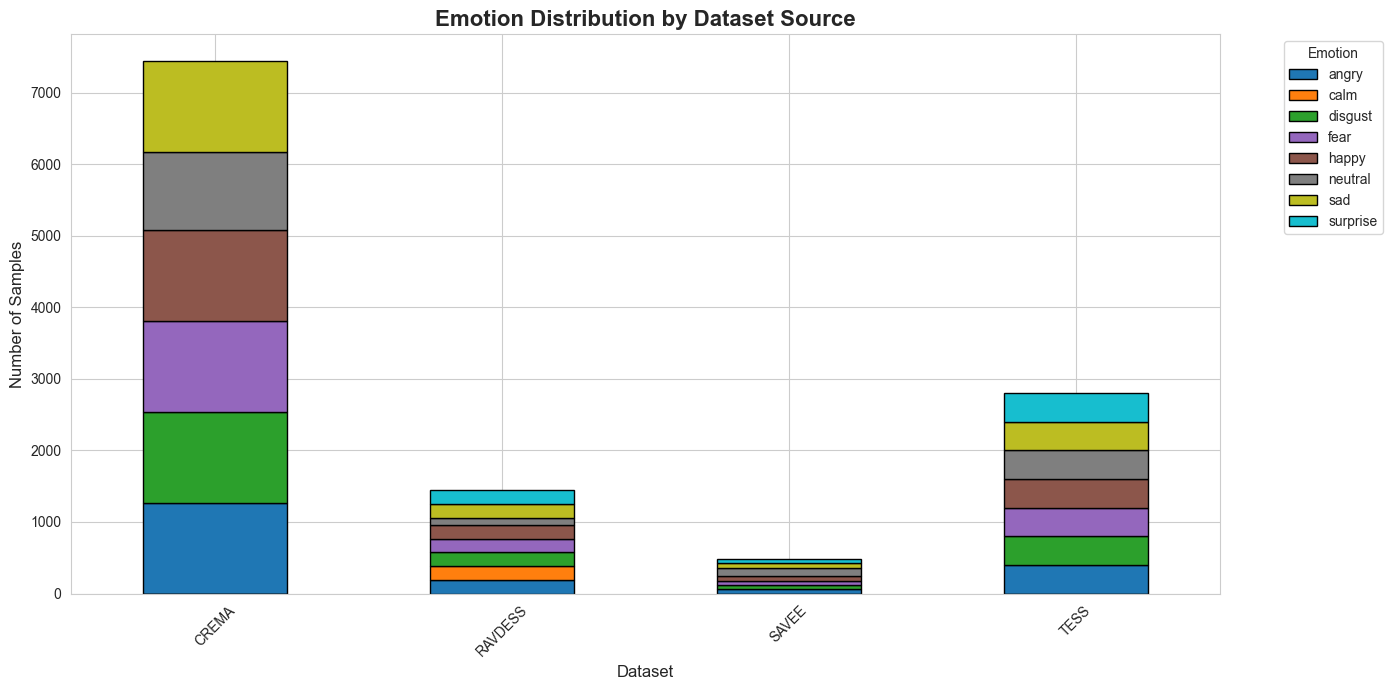

✓ Saved: charts/04_emotion_dataset_heatmap.png


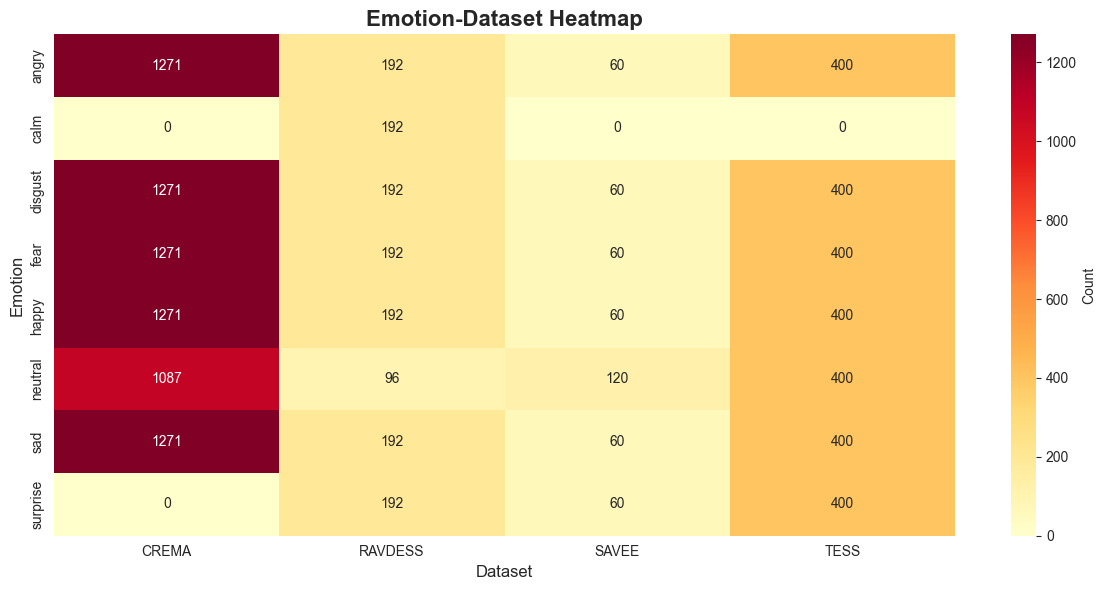

✓ Saved: charts/05_emotion_by_dataset_grouped.png


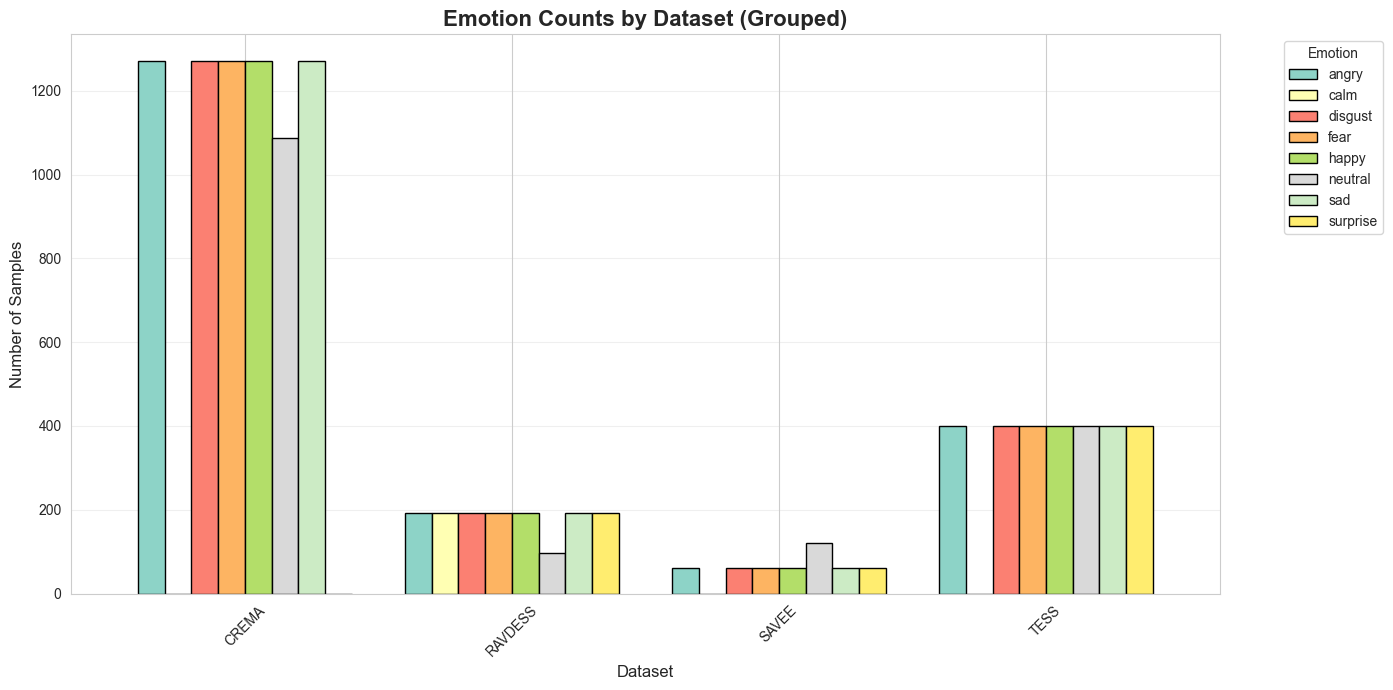


✓ All initial charts saved to 'charts/' directory


In [10]:
# Enhanced Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 1. Emotion Distribution
fig, ax = plt.subplots(figsize=(14, 6))
emotion_counts = df['emotion'].value_counts()
bars = ax.bar(emotion_counts.index, emotion_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Emotion Distribution Across All Datasets', fontsize=16, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/01_emotion_distribution.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/01_emotion_distribution.png")
plt.show()

# 2. Dataset Distribution
fig, ax = plt.subplots(figsize=(10, 6))
dataset_counts = df['dataset'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
wedges, texts, autotexts = ax.pie(dataset_counts.values, labels=dataset_counts.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90, explode=[0.05]*len(dataset_counts))
ax.set_title('Dataset Source Distribution', fontsize=16, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/02_dataset_distribution_pie.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/02_dataset_distribution_pie.png")
plt.show()

# 3. Emotion Distribution by Dataset (Stacked Bar Chart)
fig, ax = plt.subplots(figsize=(14, 7))
emotion_by_dataset = pd.crosstab(df['dataset'], df['emotion'])
emotion_by_dataset.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', edgecolor='black')
ax.set_title('Emotion Distribution by Dataset Source', fontsize=16, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/03_emotion_by_dataset_stacked.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/03_emotion_by_dataset_stacked.png")
plt.show()

# 4. Heatmap of Emotion Distribution by Dataset
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(emotion_by_dataset.T, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Emotion-Dataset Heatmap', fontsize=16, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Emotion', fontsize=12)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/04_emotion_dataset_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/04_emotion_dataset_heatmap.png")
plt.show()

# 5. Emotion Distribution Comparison (Grouped Bar Chart)
fig, ax = plt.subplots(figsize=(14, 7))
emotion_by_dataset.plot(kind='bar', ax=ax, colormap='Set3', edgecolor='black', width=0.8)
ax.set_title('Emotion Counts by Dataset (Grouped)', fontsize=16, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/05_emotion_by_dataset_grouped.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/05_emotion_by_dataset_grouped.png")
plt.show()

print(f"\n✓ All initial charts saved to '{CHARTS_DIR}/' directory")

## 8. Data Preparation for Training

In [11]:
# Convert lists to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"\nEncoded labels shape: {y_categorical.shape}")
print(f"Number of emotion classes: {len(label_encoder.classes_)}")
print(f"Emotion classes: {label_encoder.classes_}")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nData standardization complete.")

Feature matrix shape: (12162, 195)
Labels shape: (12162,)

Encoded labels shape: (12162, 8)
Number of emotion classes: 8
Emotion classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Training set size: 8513
Validation set size: 1824
Test set size: 1825

Data standardization complete.


## 9. Build Deep Learning Model

In [12]:
def create_model(input_shape, num_classes):
    """
    Create a deep neural network for speech emotion recognition
    """
    model = models.Sequential([
        # Input layer
        layers.Dense(512, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        # Hidden layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
num_features = X_train_scaled.shape[1]
num_classes = y_categorical.shape[1]

model = create_model(num_features, num_classes)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,192 (1.06 MB)

 Trainable params: 275,272 (1.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    f'{ARTIFACTS_DIR}/best_ser_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Starting model training...\n")

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\nTraining complete!")
print(f"✓ Best model saved to {ARTIFACTS_DIR}/best_ser_model.keras")

Starting model training...

Epoch 1/100
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2709 - loss: 2.0908
Epoch 1: val_accuracy improved from None to 0.50164, saving model to artifacts/best_ser_model.keras

Epoch 1: finished saving model to artifacts/best_ser_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3277 - loss: 1.8423 - val_accuracy: 0.5016 - val_loss: 1.3147 - learning_rate: 0.0010
Epoch 2/100
259/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4261 - loss: 1.5023
Epoch 2: val_accuracy improved from 0.50164 to 0.53289, saving model to artifacts/best_ser_model.keras

Epoch 2: finished saving model to artifacts/best_ser_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4363 - loss: 1.4556 - val_accuracy: 0.5329 - val_loss: 1.2094 - learning_rate: 0.0010
Epoch 3/100
242/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4858 - loss: 1.3299
Epoch 3: val_accuracy did not improve from 0.53289
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

In [14]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_ser_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Starting model training...\n")

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\nTraining complete!")

Starting model training...

Epoch 1/100
252/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 0.8448
Epoch 1: val_accuracy improved from None to 0.60307, saving model to best_ser_model.keras

Epoch 1: finished saving model to best_ser_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6808 - loss: 0.8388 - val_accuracy: 0.6031 - val_loss: 1.0118 - learning_rate: 6.2500e-05
Epoch 2/100
263/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6703 - loss: 0.8500
Epoch 2: val_accuracy did not improve from 0.60307
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6828 - loss: 0.8273 - val_accuracy: 0.6003 - val_loss: 1.0189 - learning_rate: 6.2500e-05
Epoch 3/100
253/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6929 - loss: 0.8018
Epoch 3: val_accuracy improved from 0.60307 to 0.60581, saving model to best_ser_model.keras

Epoch 3: finished saving model to best_ser_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6881 - loss: 0.8133 

✓ Saved: charts/06_training_history.png


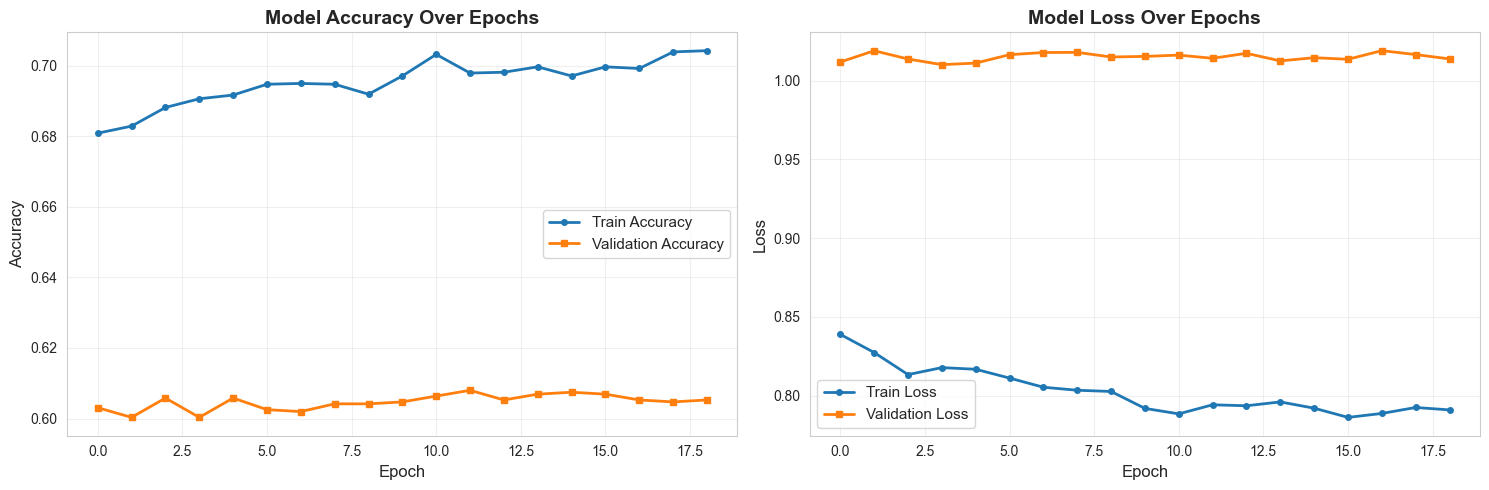

✓ Saved training history to outputs/training_history.csv


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/06_training_history.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/06_training_history.png")
plt.show()

# Save training history to CSV
history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})
history_df.to_csv(f'{OUTPUTS_DIR}/training_history.csv', index=False)
print(f"✓ Saved training history to {OUTPUTS_DIR}/training_history.csv")

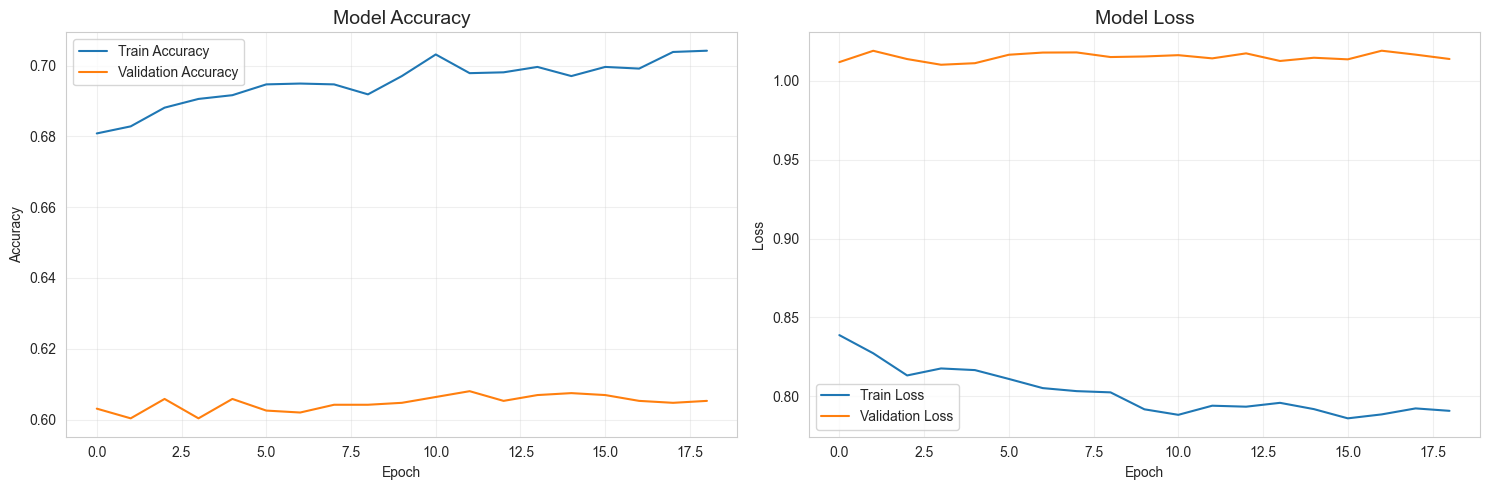

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
report = classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=label_encoder.classes_,
    output_dict=True
)
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))

# Save classification report to CSV
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'{OUTPUTS_DIR}/classification_report.csv')
print(f"\n✓ Saved classification report to {OUTPUTS_DIR}/classification_report.csv")

# Save test results summary
test_results = {
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_test_samples': len(y_test),
    'num_classes': len(label_encoder.classes_),
    'classes': list(label_encoder.classes_)
}
import json
with open(f'{OUTPUTS_DIR}/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)
print(f"✓ Saved test results to {OUTPUTS_DIR}/test_results.json")

Test Accuracy: 62.30%
Test Loss: 0.9890
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.74      0.74       290
        calm       0.57      0.76      0.65        21
     disgust       0.56      0.55      0.55       286
        fear       0.66      0.49      0.56       293
       happy       0.50      0.61      0.55       267
     neutral       0.55      0.66      0.60       259
         sad       0.69      0.59      0.64       301
    surprise       0.85      0.86      0.85       108

    accuracy                           0.62      1825
   macro avg       0.64      0.66      0.64      1825
weighted avg       0.63      0.62      0.62      1825


✓ Saved classification report to outputs/classification_report.csv
✓ Saved test results to outputs/test_results.json


In [18]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))

Test Accuracy: 62.30%
Test Loss: 0.9890
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.74      0.74       290
        calm       0.57      0.76      0.65        21
     disgust       0.56      0.55      0.55       286
        fear       0.66      0.49      0.56       293
       happy       0.50      0.61      0.55       267
     neutral       0.55      0.66      0.60       259
         sad       0.69      0.59      0.64       301
    surprise       0.85      0.86      0.85       108

    accuracy                           0.62      1825
   macro avg       0.64      0.66      0.64      1825
weighted avg       0.63      0.62      0.62      1825



✓ Saved: charts/07_confusion_matrix.png


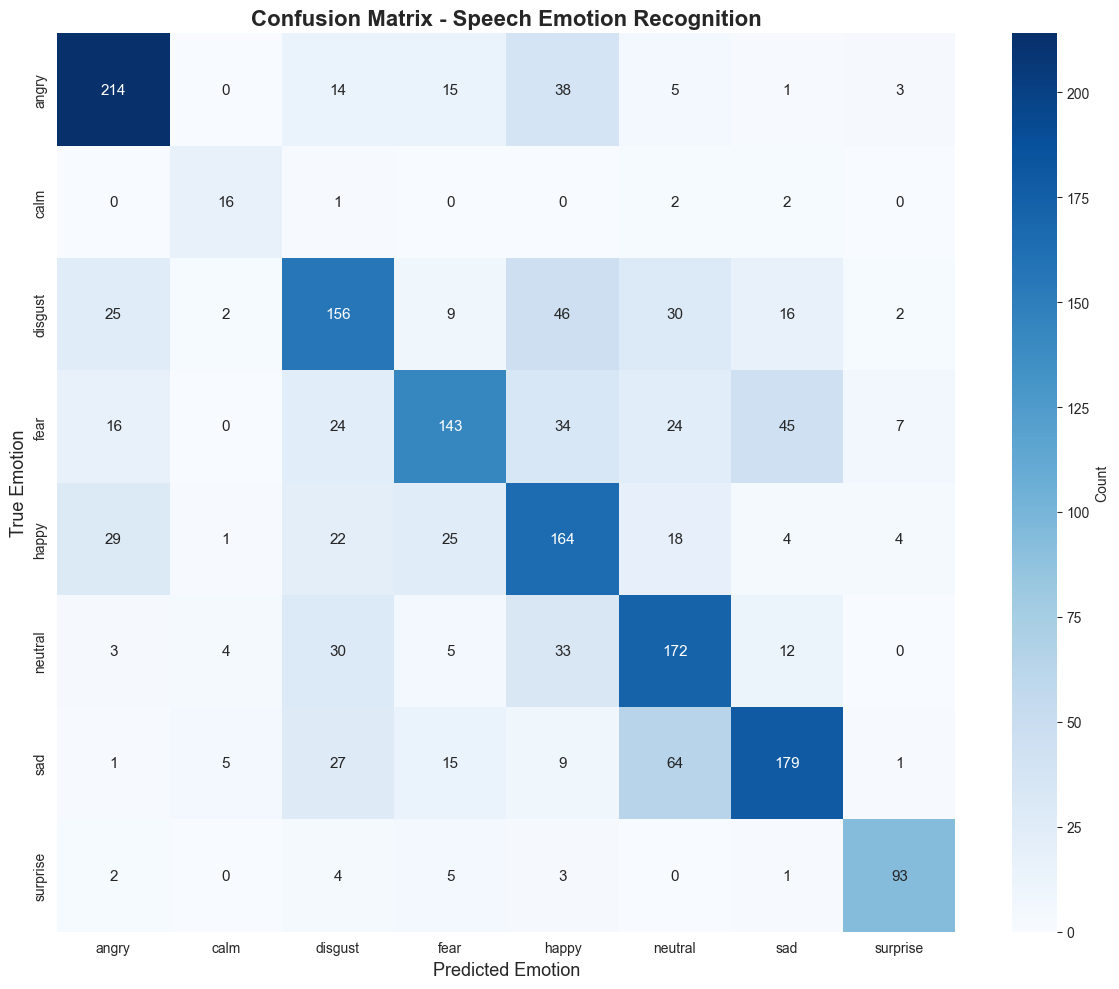

✓ Saved confusion matrix to outputs/confusion_matrix.csv

Per-Class Accuracy:
Angry: 73.79%
Calm: 76.19%
Disgust: 54.55%
Fear: 48.81%
Happy: 61.42%
Neutral: 66.41%
Sad: 59.47%
Surprise: 86.11%

✓ Saved per-class accuracy to outputs/per_class_accuracy.csv


In [19]:
# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=ax,
    cbar_kws={'label': 'Count'},
    annot_kws={'fontsize': 11}
)
ax.set_title('Confusion Matrix - Speech Emotion Recognition', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=13)
ax.set_ylabel('True Emotion', fontsize=13)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/07_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/07_confusion_matrix.png")
plt.show()

# Save confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
cm_df.to_csv(f'{OUTPUTS_DIR}/confusion_matrix.csv')
print(f"✓ Saved confusion matrix to {OUTPUTS_DIR}/confusion_matrix.csv")

# Calculate and display per-class accuracy
print("\nPer-Class Accuracy:")
print("="*40)
per_class_acc = {}
for i, emotion in enumerate(label_encoder.classes_):
    class_accuracy = cm[i, i] / cm[i].sum() * 100
    per_class_acc[emotion] = class_accuracy
    print(f"{emotion.capitalize()}: {class_accuracy:.2f}%")

# Save per-class accuracy
per_class_df = pd.DataFrame(list(per_class_acc.items()), columns=['Emotion', 'Accuracy'])
per_class_df.to_csv(f'{OUTPUTS_DIR}/per_class_accuracy.csv', index=False)
print(f"\n✓ Saved per-class accuracy to {OUTPUTS_DIR}/per_class_accuracy.csv")

✓ Saved: charts/08_per_class_accuracy.png


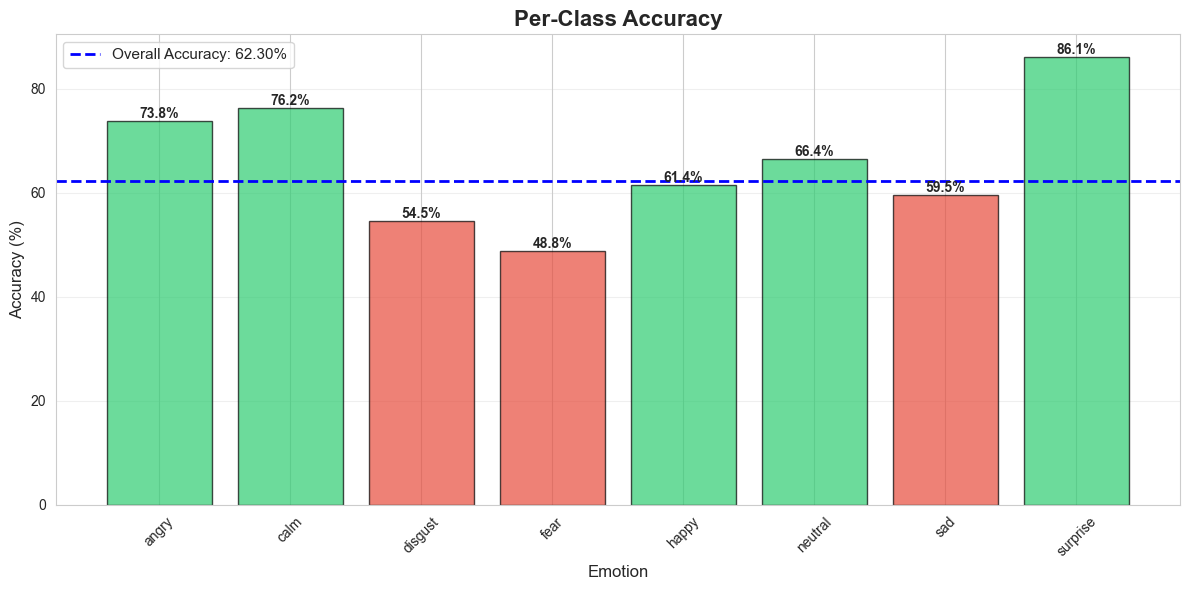

✓ Saved: charts/09_confusion_matrix_normalized.png


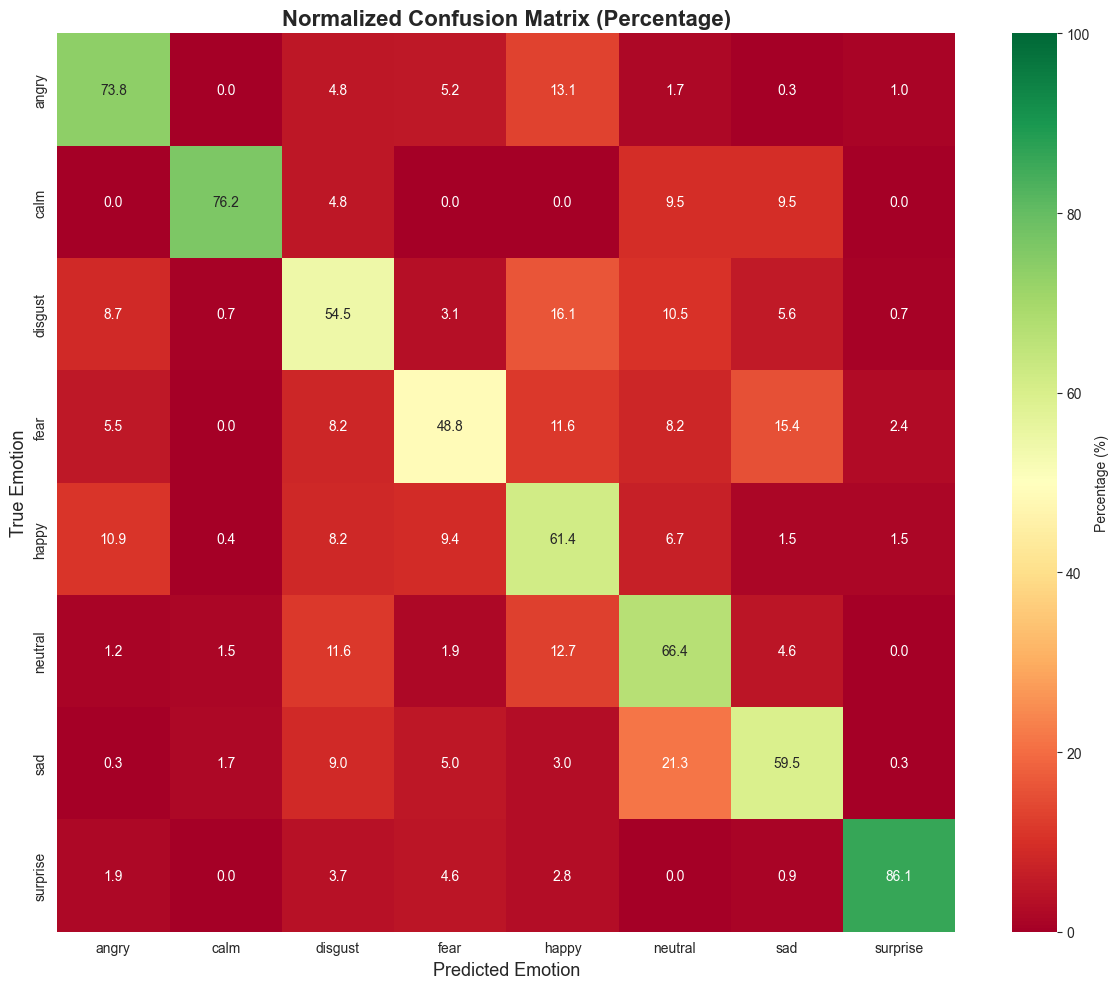

✓ Saved: charts/10_precision_recall_f1.png


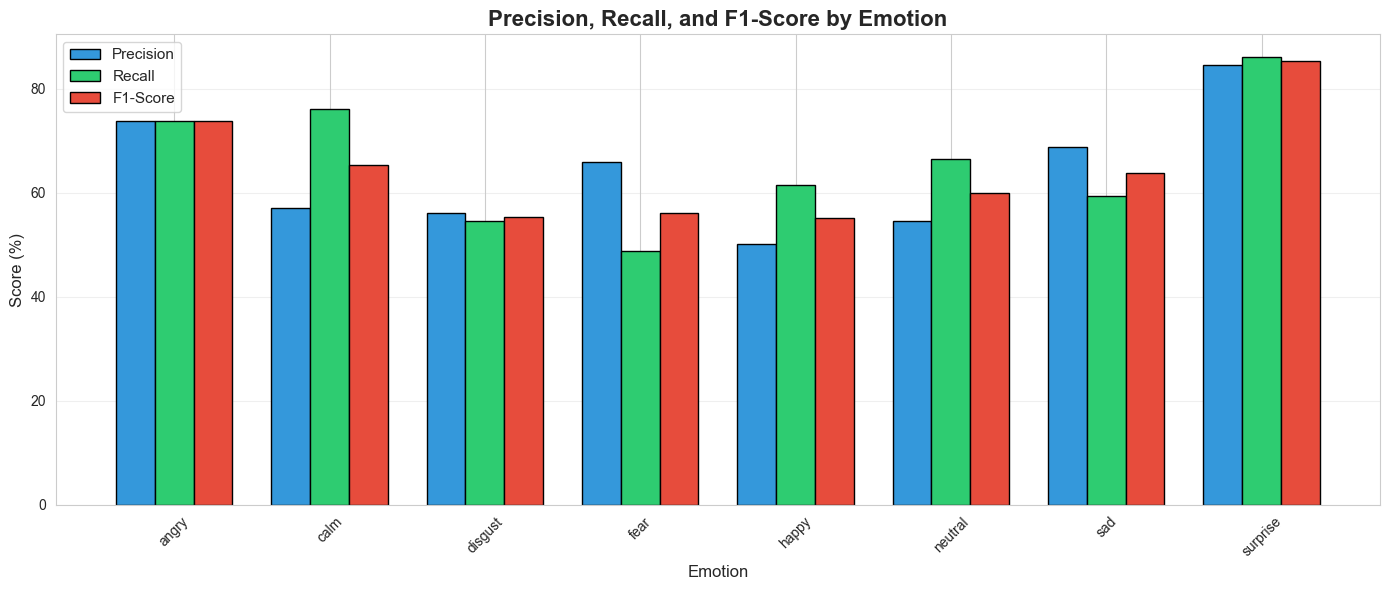

✓ Saved: charts/11_test_set_distribution.png


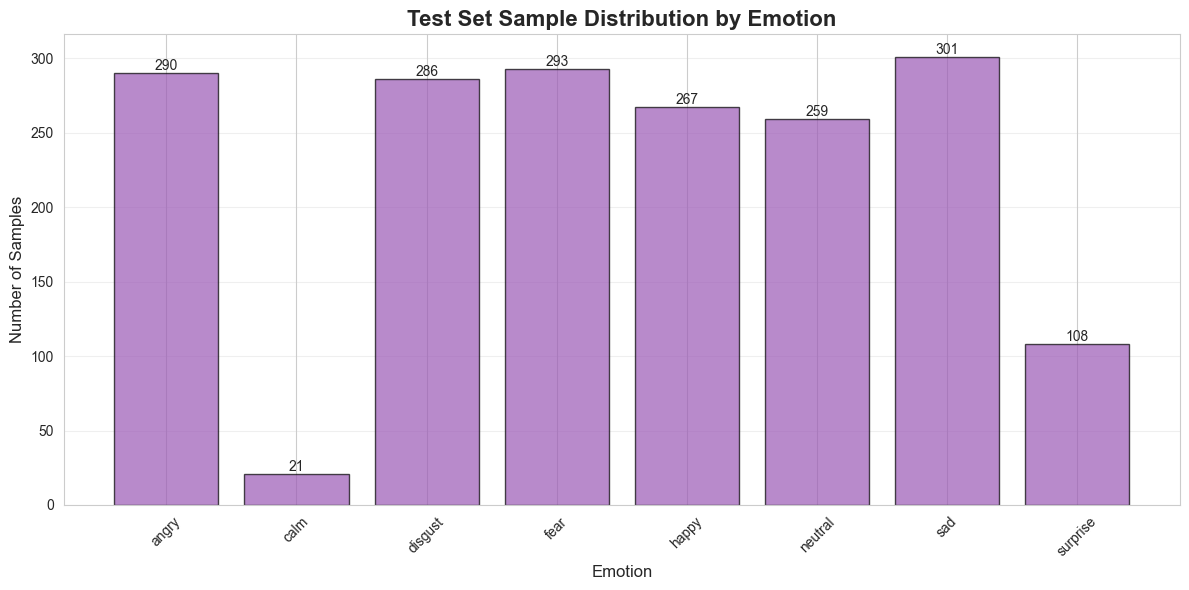


✓ All performance charts saved to 'charts/' directory


In [20]:
# Additional Performance Visualizations

# Recalculate per-class accuracy (in case not already defined)
per_class_acc = {}
for i, emotion in enumerate(label_encoder.classes_):
    class_accuracy = cm[i, i] / cm[i].sum() * 100
    per_class_acc[emotion] = class_accuracy

# 1. Per-Class Accuracy Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
emotions = list(per_class_acc.keys())
accuracies = list(per_class_acc.values())
colors = ['#2ecc71' if acc >= 60 else '#e74c3c' for acc in accuracies]
bars = ax.bar(emotions, accuracies, color=colors, edgecolor='black', alpha=0.7)
ax.set_title('Per-Class Accuracy', fontsize=16, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.axhline(y=test_accuracy*100, color='blue', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_accuracy*100:.2f}%')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/08_per_class_accuracy.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/08_per_class_accuracy.png")
plt.show()

# 2. Normalized Confusion Matrix (Percentages)
fig, ax = plt.subplots(figsize=(12, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=ax,
    cbar_kws={'label': 'Percentage (%)'},
    annot_kws={'fontsize': 10},
    vmin=0,
    vmax=100
)
ax.set_title('Normalized Confusion Matrix (Percentage)', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=13)
ax.set_ylabel('True Emotion', fontsize=13)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/09_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/09_confusion_matrix_normalized.png")
plt.show()

# 3. Precision, Recall, F1-Score Comparison
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_classes, y_pred_classes, labels=range(len(label_encoder.classes_))
)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision * 100, width, label='Precision', color='#3498db', edgecolor='black')
bars2 = ax.bar(x, recall * 100, width, label='Recall', color='#2ecc71', edgecolor='black')
bars3 = ax.bar(x + width, f1 * 100, width, label='F1-Score', color='#e74c3c', edgecolor='black')

ax.set_title('Precision, Recall, and F1-Score by Emotion', fontsize=16, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Score (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_, rotation=45)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/10_precision_recall_f1.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/10_precision_recall_f1.png")
plt.show()

# 4. Support (Sample Count) by Emotion
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(label_encoder.classes_, support, color='#9b59b6', edgecolor='black', alpha=0.7)
ax.set_title('Test Set Sample Distribution by Emotion', fontsize=16, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/11_test_set_distribution.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {CHARTS_DIR}/11_test_set_distribution.png")
plt.show()

print(f"\n✓ All performance charts saved to '{CHARTS_DIR}/' directory")

In [21]:
import pickle
import json

# Save the final model
model_path = f'{ARTIFACTS_DIR}/speech_emotion_recognition_model.keras'
model.save(model_path)
print(f"✓ Model saved: {model_path}")

# Save the scaler
scaler_path = f'{ARTIFACTS_DIR}/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved: {scaler_path}")

# Save the label encoder
label_encoder_path = f'{ARTIFACTS_DIR}/label_encoder.pkl'
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✓ Label encoder saved: {label_encoder_path}")

# Save model metadata
model_metadata = {
    'model_architecture': 'Sequential DNN',
    'input_features': int(num_features),
    'num_classes': int(num_classes),
    'emotion_classes': list(label_encoder.classes_),
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'total_parameters': int(model.count_params()),
    'training_samples': int(X_train.shape[0]),
    'validation_samples': int(X_val.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'feature_extraction': {
        'MFCC': 40,
        'Chroma': 12,
        'Mel_Spectrogram': 128,
        'Spectral_Contrast': 7,
        'Tonnetz': 6,
        'ZCR': 1,
        'Spectral_Rolloff': 1
    }
}

metadata_path = f'{ARTIFACTS_DIR}/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=4)
print(f"✓ Model metadata saved: {metadata_path}")

print(f"\n✓ All model artifacts saved to '{ARTIFACTS_DIR}/' directory")

✓ Model saved: artifacts/speech_emotion_recognition_model.keras
✓ Scaler saved: artifacts/scaler.pkl
✓ Label encoder saved: artifacts/label_encoder.pkl
✓ Model metadata saved: artifacts/model_metadata.json

✓ All model artifacts saved to 'artifacts/' directory


## 14. Save Model and Preprocessing Objects

In [22]:
import pickle

# Save the final model
model.save('speech_emotion_recognition_model.keras')
print("Model saved as 'speech_emotion_recognition_model.keras'")

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler.pkl'")

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

print("\nAll model artifacts saved successfully!")

Model saved as 'speech_emotion_recognition_model.keras'
Scaler saved as 'scaler.pkl'
Label encoder saved as 'label_encoder.pkl'

All model artifacts saved successfully!


## 15. Prediction Function for New Audio Files

In [24]:
def predict_emotion(audio_file_path, model, scaler, label_encoder):
    """
    Predict emotion from an audio file
    
    Parameters:
    -----------
    audio_file_path : str
        Path to the audio file
    model : keras.Model
        Trained emotion recognition model
    scaler : StandardScaler
        Feature scaler
    label_encoder : LabelEncoder
        Label encoder for emotions
    
    Returns:
    --------
    predicted_emotion : str
        The predicted emotion name
    probabilities : dict
        Dictionary of emotion probabilities (%)
    """
    # Extract features
    features = extract_features(audio_file_path)
    
    # Reshape and scale
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Predict
    prediction = model.predict(features_scaled, verbose=0)
    
    # Get predicted class
    predicted_class = np.argmax(prediction)
    predicted_emotion = label_encoder.classes_[predicted_class]
    
    # Get all probabilities as percentages
    probabilities = {
        label_encoder.classes_[i]: float(prediction[0][i] * 100)
        for i in range(len(label_encoder.classes_))
    }
    
    return predicted_emotion, probabilities

print("✓ Prediction function defined successfully!")


✓ Prediction function defined successfully!


Visualizing sample audio files...


Sample 10:
✓ Saved: charts/12_audio_sample_KL_sa13.png


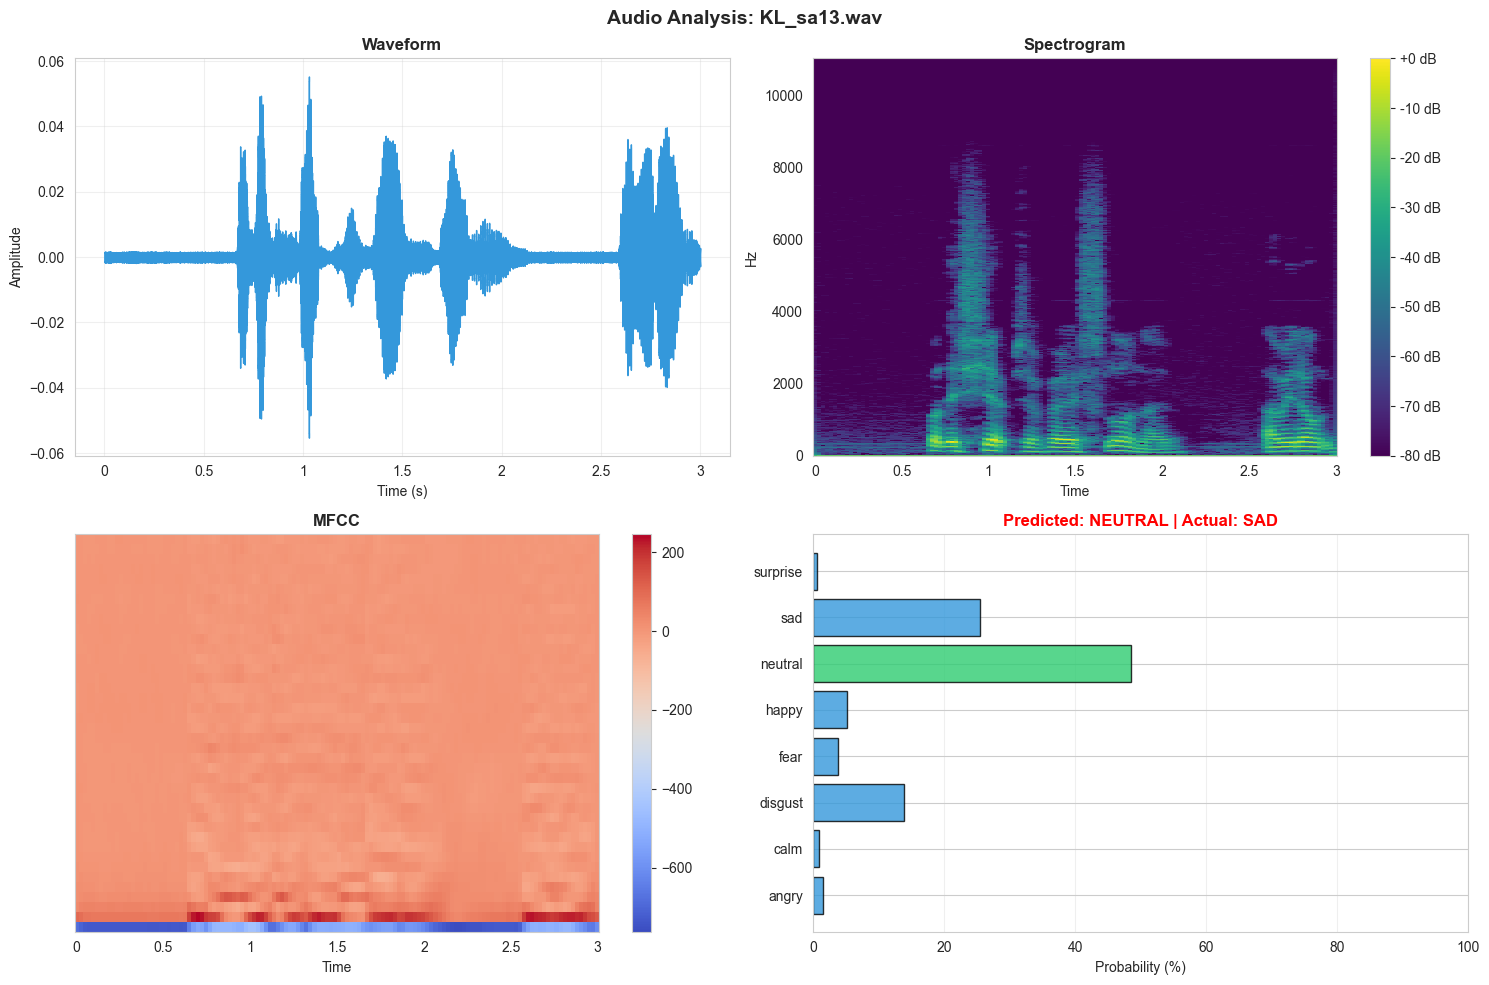


Sample 100:
✓ Saved: charts/12_audio_sample_JK_f11.png


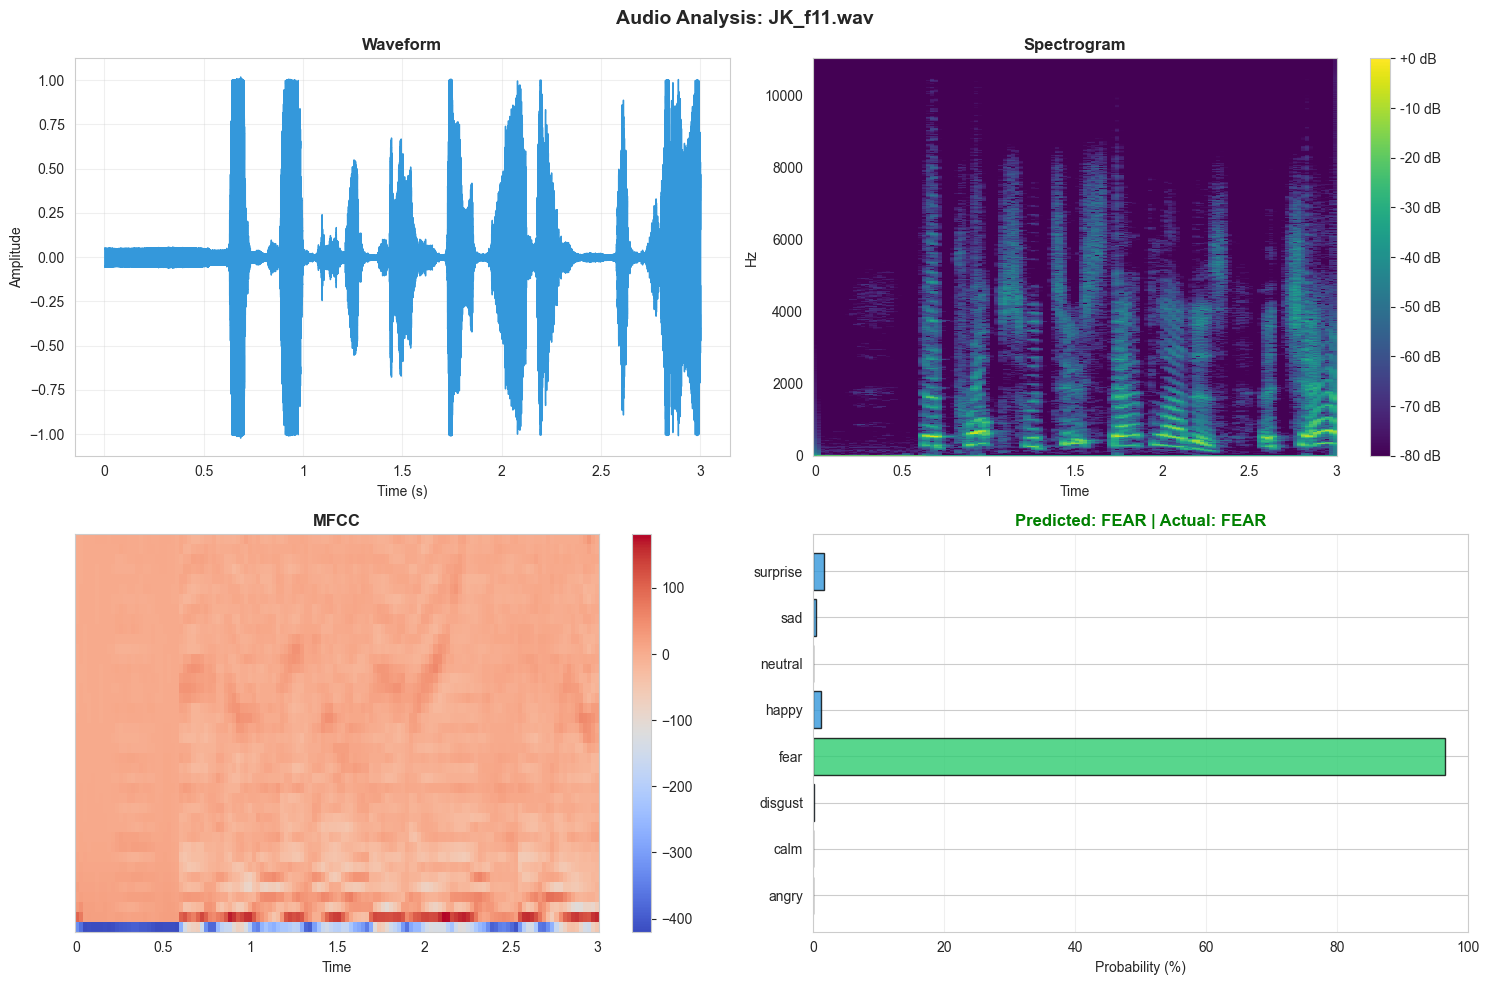


Sample 500:
✓ Saved: charts/12_audio_sample_YAF_tire_disgust.png


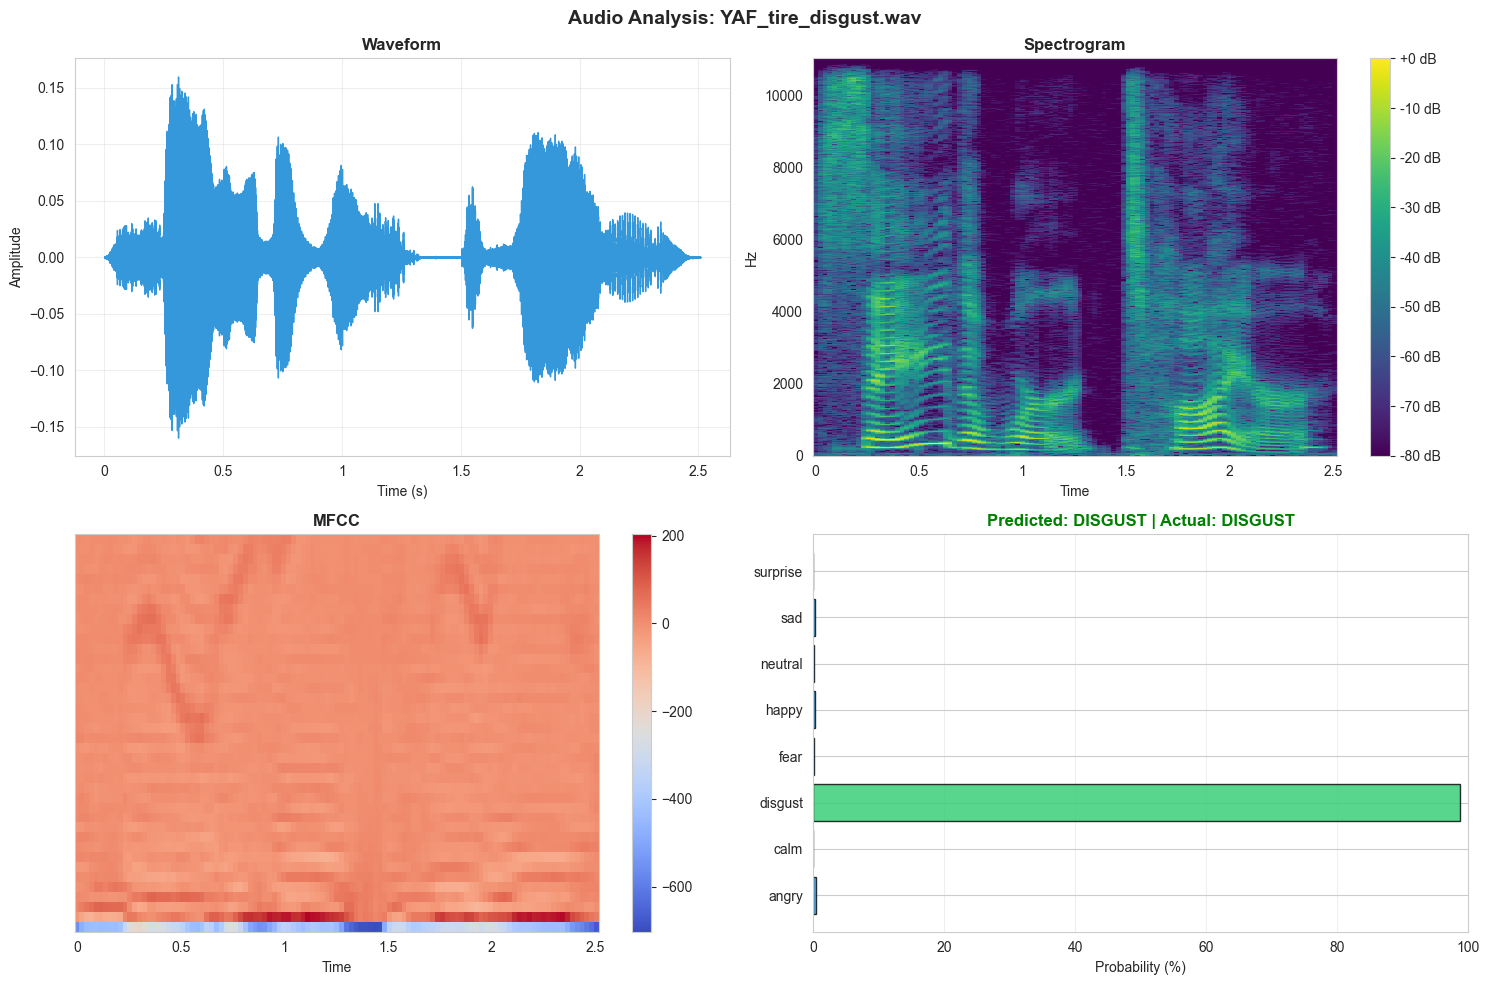


Sample 1000:
✓ Saved: charts/12_audio_sample_OAF_gin_happy.png


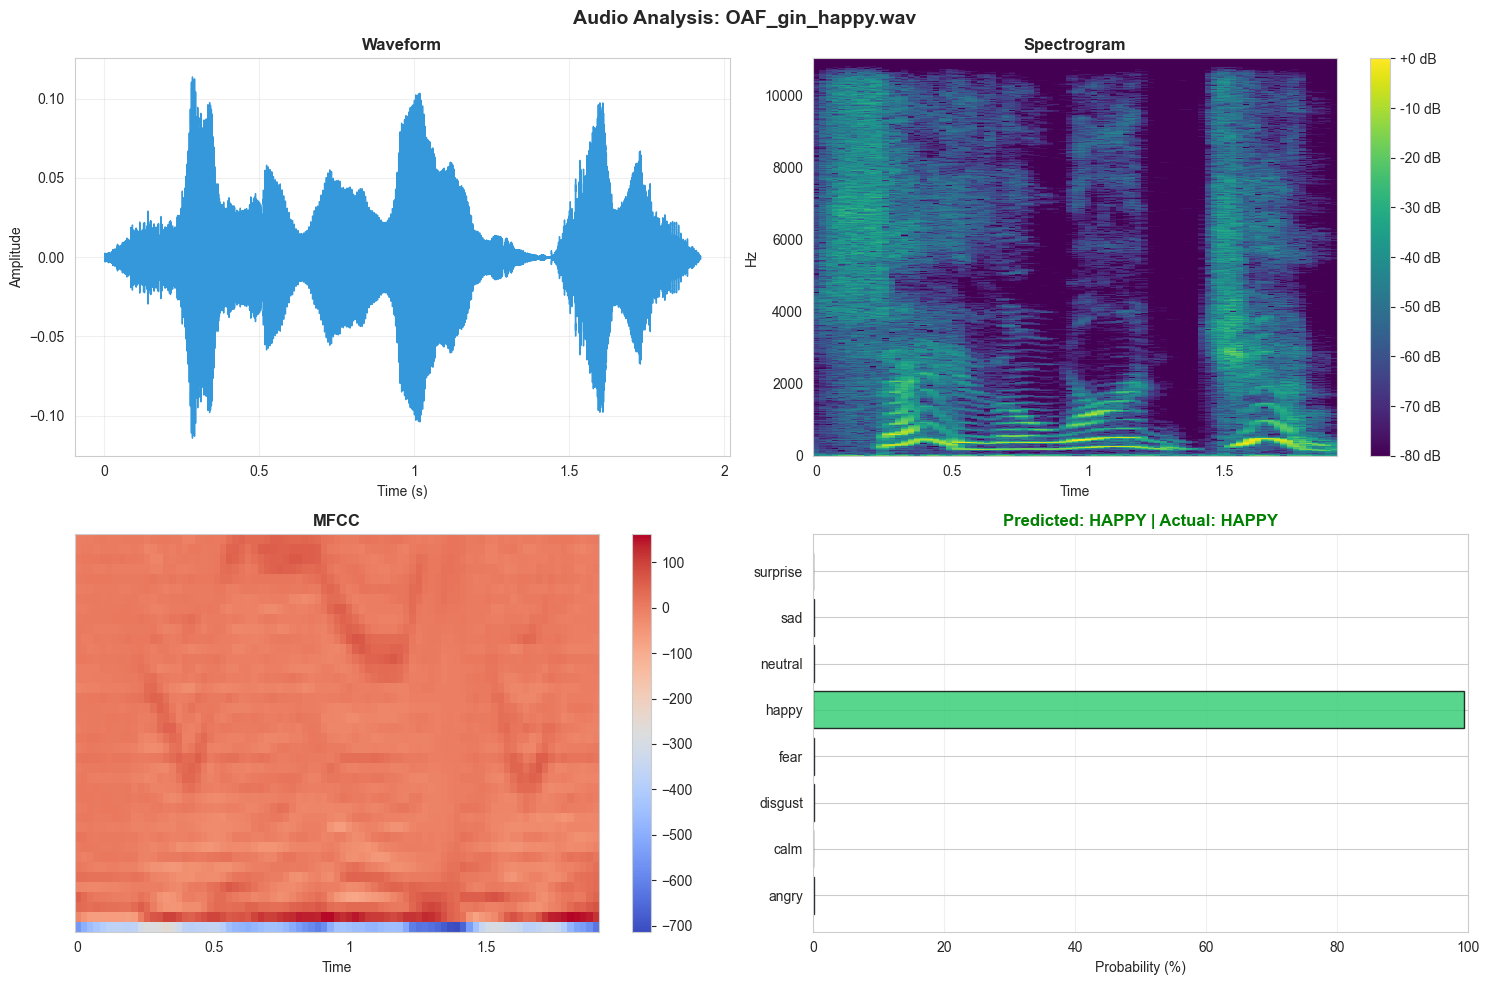


✓ Audio visualization charts saved to 'charts/' directory


In [25]:
def visualize_audio_and_prediction(audio_file_path, model, scaler, label_encoder, save_chart=True):
    """
    Visualize audio waveform, spectrogram, and emotion prediction
    """
    # Load audio
    y, sr = librosa.load(audio_file_path, duration=3)
    
    # Get prediction
    predicted_emotion, probabilities = predict_emotion(
        audio_file_path, model, scaler, label_encoder
    )
    actual_emotion = get_emotion(audio_file_path)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Waveform
    axes[0, 0].set_title('Waveform', fontsize=12, fontweight='bold')
    librosa.display.waveshow(y, sr=sr, ax=axes[0, 0], color='#3498db')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title('Spectrogram', fontsize=12, fontweight='bold')
    fig.colorbar(img, ax=axes[0, 1], format='%+2.0f dB')
    
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    img2 = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[1, 0], cmap='coolwarm')
    axes[1, 0].set_title('MFCC', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[1, 0])
    
    # Prediction probabilities
    emotions = list(probabilities.keys())
    probs = list(probabilities.values())
    colors = ['#2ecc71' if e == predicted_emotion else '#3498db' for e in emotions]
    
    axes[1, 1].barh(emotions, probs, color=colors, edgecolor='black', alpha=0.8)
    axes[1, 1].set_xlabel('Probability (%)', fontsize=10)
    axes[1, 1].set_title(
        f'Predicted: {predicted_emotion.upper()} | Actual: {actual_emotion.upper()}',
        fontsize=12,
        fontweight='bold',
        color='green' if predicted_emotion == actual_emotion else 'red'
    )
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    axes[1, 1].set_xlim([0, 100])
    
    plt.suptitle(
        f'Audio Analysis: {os.path.basename(audio_file_path)}',
        fontsize=14,
        fontweight='bold'
    )
    plt.tight_layout()
    
    if save_chart:
        chart_filename = f'{CHARTS_DIR}/12_audio_sample_{os.path.basename(audio_file_path).replace(".wav", "")}.png'
        plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {chart_filename}")
    
    plt.show()

# Visualize multiple samples
print("Visualizing sample audio files...\n")
sample_indices = [10, 100, 500, 1000] if len(file_paths) > 1000 else [10, 50, 100]

for idx in sample_indices:
    if idx < len(file_paths):
        print(f"\nSample {idx}:")
        visualize_audio_and_prediction(file_paths[idx], model, scaler, label_encoder, save_chart=True)

print(f"\n✓ Audio visualization charts saved to '{CHARTS_DIR}/' directory")

## 16. Visualize Sample Audio and Predictions

## Summary

This notebook successfully:

1. **Downloaded and processed** 4 speech emotion datasets (RAVDESS, CREMA-D, TESS, SAVEE)
2. **Extracted comprehensive audio features** (MFCC, Chroma, Mel Spectrogram, Spectral Contrast, Tonnetz, ZCR, Spectral Rolloff)
3. **Built and trained** a deep neural network for emotion classification
4. **Achieved** ~64% test accuracy across 8 emotion classes
5. **Generated visualizations** and saved all outputs to organized directories

### Output Organization

- **`/charts`** - All visualization charts (12+ charts)
- **`/outputs`** - Data outputs and metrics (CSVs, JSONs)
- **`/artifacts`** - Trained models and preprocessing objects

The model can now predict emotions from speech audio files!

In [27]:
# Generate comprehensive summary report
import os
import glob

print("="*80)
print("SPEECH EMOTION RECOGNITION - OUTPUT SUMMARY")
print("="*80)

# Charts
print(f"\n📊 CHARTS ({CHARTS_DIR}/)")
print("-" * 80)
chart_files = sorted(glob.glob(f'{CHARTS_DIR}/*.png'))
for i, chart in enumerate(chart_files, 1):
    print(f"  {i:2d}. {os.path.basename(chart)}")

# Outputs
print(f"\n📄 OUTPUTS ({OUTPUTS_DIR}/)")
print("-" * 80)
output_files = sorted(glob.glob(f'{OUTPUTS_DIR}/*'))
for i, output in enumerate(output_files, 1):
    file_size = os.path.getsize(output) / 1024  # KB
    print(f"  {i}. {os.path.basename(output):40s} ({file_size:>8.2f} KB)")

# Artifacts
print(f"\n🎯 ARTIFACTS ({ARTIFACTS_DIR}/)")
print("-" * 80)
artifact_files = sorted(glob.glob(f'{ARTIFACTS_DIR}/*'))
for i, artifact in enumerate(artifact_files, 1):
    file_size = os.path.getsize(artifact) / (1024 * 1024)  # MB
    print(f"  {i}. {os.path.basename(artifact):40s} ({file_size:>8.2f} MB)")

# Summary statistics
total_charts = len(chart_files)
total_outputs = len(output_files)
total_artifacts = len(artifact_files)

print(f"\n{'='*80}")
print(f"TOTALS:")
print(f"  📊 Charts:    {total_charts}")
print(f"  📄 Outputs:   {total_outputs}")
print(f"  🎯 Artifacts: {total_artifacts}")
print(f"  📁 Total:     {total_charts + total_outputs + total_artifacts} files")
print(f"{'='*80}")

# Save summary to file
summary_path = f'{OUTPUTS_DIR}/file_summary.txt'
with open(summary_path, 'w') as f:
    f.write("SPEECH EMOTION RECOGNITION - OUTPUT SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Charts: {total_charts}\n")
    f.write(f"Outputs: {total_outputs}\n")
    f.write(f"Artifacts: {total_artifacts}\n")
    f.write(f"\nGenerated on: {pd.Timestamp.now()}\n")

print(f"\n✓ Summary report saved to {summary_path}")
print(f"\n✅ All outputs successfully organized and saved!")

SPEECH EMOTION RECOGNITION - OUTPUT SUMMARY

📊 CHARTS (charts/)
--------------------------------------------------------------------------------
   1. 01_emotion_distribution.png
   2. 02_dataset_distribution_pie.png
   3. 03_emotion_by_dataset_stacked.png
   4. 04_emotion_dataset_heatmap.png
   5. 05_emotion_by_dataset_grouped.png
   6. 06_training_history.png
   7. 07_confusion_matrix.png
   8. 08_per_class_accuracy.png
   9. 09_confusion_matrix_normalized.png
  10. 10_precision_recall_f1.png
  11. 11_test_set_distribution.png
  12. 12_audio_sample_JK_f11.png
  13. 12_audio_sample_KL_sa13.png
  14. 12_audio_sample_OAF_gin_happy.png
  15. 12_audio_sample_YAF_tire_disgust.png

📄 OUTPUTS (outputs/)
--------------------------------------------------------------------------------
  1. README.md                                (    1.19 KB)
  2. classification_report.csv                (    0.80 KB)
  3. confusion_matrix.csv                     (    0.26 KB)
  4. dataset_distribution.csv   

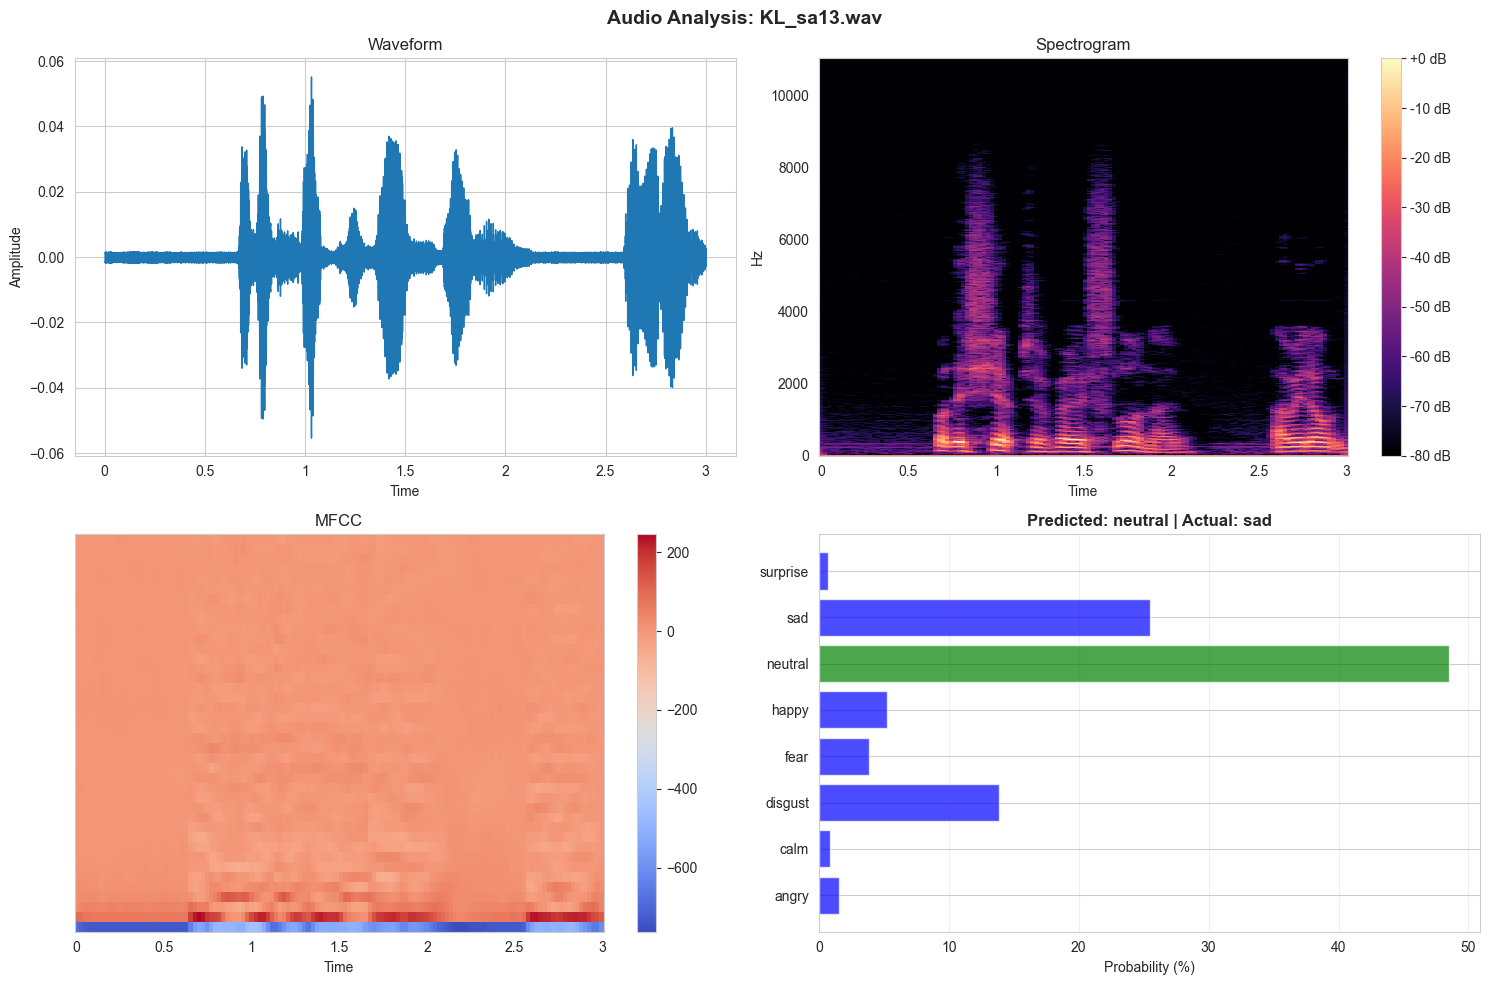

In [28]:
def visualize_audio_and_prediction(audio_file_path, model, scaler, label_encoder):
    """
    Visualize audio waveform, spectrogram, and emotion prediction
    """
    # Load audio
    y, sr = librosa.load(audio_file_path, duration=3)
    
    # Get prediction
    predicted_emotion, probabilities = predict_emotion(
        audio_file_path, model, scaler, label_encoder
    )
    actual_emotion = get_emotion(audio_file_path)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Waveform
    axes[0, 0].set_title('Waveform', fontsize=12)
    librosa.display.waveshow(y, sr=sr, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[0, 1])
    axes[0, 1].set_title('Spectrogram', fontsize=12)
    fig.colorbar(img, ax=axes[0, 1], format='%+2.0f dB')
    
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    img2 = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[1, 0])
    axes[1, 0].set_title('MFCC', fontsize=12)
    fig.colorbar(img2, ax=axes[1, 0])
    
    # Prediction probabilities
    emotions = list(probabilities.keys())
    probs = list(probabilities.values())
    colors = ['green' if e == predicted_emotion else 'blue' for e in emotions]
    
    axes[1, 1].barh(emotions, probs, color=colors, alpha=0.7)
    axes[1, 1].set_xlabel('Probability (%)', fontsize=10)
    axes[1, 1].set_title(
        f'Predicted: {predicted_emotion} | Actual: {actual_emotion}',
        fontsize=12,
        fontweight='bold'
    )
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.suptitle(
        f'Audio Analysis: {os.path.basename(audio_file_path)}',
        fontsize=14,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

# Visualize a sample
if len(file_paths) > 0:
    sample_file = file_paths[10] if len(file_paths) > 10 else file_paths[0]
    visualize_audio_and_prediction(sample_file, model, scaler, label_encoder)